In [30]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


# Chargement du dataset

On récupère le dataset composé d'images de chiffre de 8x8 pixels

In [4]:
# Chargement du dataset
digits = load_digits()

# Analyse du dataset

Affichage des 64 premiers chiffres

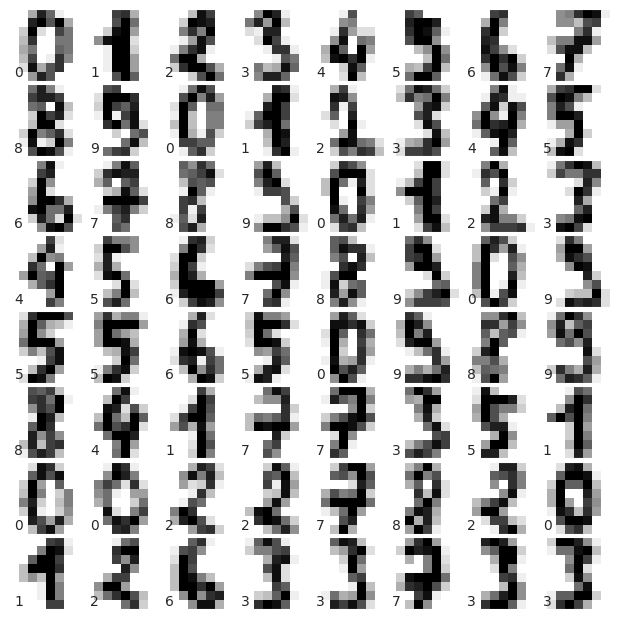

In [28]:
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [5]:
# Affichage des clés du dataset
print(f"Clés de l'objet 'digits': {list(digits.keys())}")
# Inspection des dimensions des tableaux
print(f"Dimension du tableau 'data' (échantillons, features): {digits.data.shape}")
print(f"Dimension du tableau 'target' (target): {digits.target.shape}")
print(f"Dimension du tableau 'images' matrice de 8x8 (échantillons, hauteur, largeur): {digits.images.shape}")

# Affichage du nombre de classes uniques
print(f"Targets, les chiffre de 0 à 9 : {digits.target_names}")

Clés de l'objet 'digits': ['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR']
Dimension du tableau 'data' (échantillons, features): (1797, 64)
Dimension du tableau 'target' (étiquettes): (1797,)
Dimension du tableau 'images' (échantillons, hauteur, largeur): (1797, 8, 8)
Targets, les chiffre de 0 à 9 : [0 1 2 3 4 5 6 7 8 9]


On a donc un dataset de 1797 images de 8x8 pixels classifiés représentant les chiffres manuscrits entre 0 et 9.

La représentation de ces images se trouvent dans data, il y'a 64 features, soit "l'applatissement" de la matrice de 8x8 pixels.

# Préparation des

## Split

In [8]:
# Séparation des données en features (X) et labels (y)
X = digits.data
y = digits.target

# Division en ensembles d'entraînement et de test (80% / 20%)
# test_size=0.2 signifie que 20% des données seront pour le test
# random_state=42 assure la reproductibilité de la division
# stratify=y maintient la proportion des classes dans les deux ensembles
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vérification des dimensions des ensembles créés
print(f"Dimensions de X_train: {X_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}")
print(f"Dimensions de y_train: {y_train.shape}")
print(f"Dimensions de y_test: {y_test.shape}")

Dimensions de X_train: (1437, 64)
Dimensions de X_test: (360, 64)
Dimensions de y_train: (1437,)
Dimensions de y_test: (360,)


# Normalisation des données

In [17]:
# Initialisation du scaler
scaler = StandardScaler()

# Ajustement du scaler UNIQUEMENT sur les données d'entraînement
scaler.fit(X_train)

# Application de la transformation aux deux ensembles
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Vérification de la mise à l'échelle
# La moyenne devrait être proche de 0 et l'écart-type proche de 1 pour l'ensemble d'entraînement
print(f"Moyenne de X_train_scaled (après scaling): {X_train_scaled.mean():.2f}")
print(f"Écart-type de X_train_scaled (après scaling): {X_train_scaled.std():.2f}")

# La moyenne et l'écart-type de l'ensemble de test ne seront pas exactement 0 et 1,
# car nous utilisons les paramètres calculés sur le train set. C'est le comportement attendu.
print(f"\nMoyenne de X_test_scaled (après scaling): {X_test_scaled.mean():.2f}")
print(f"Écart-type de X_test_scaled (après scaling): {X_test_scaled.std():.2f}")

Moyenne de X_train_scaled (après scaling): 0.00
Écart-type de X_train_scaled (après scaling): 0.98

Moyenne de X_test_scaled (après scaling): -0.00
Écart-type de X_test_scaled (après scaling): 1.10


# Entrainement du model

In [33]:
# Initialisation du classifieur Forêt Aléatoire
# n_estimators est le nombre d'arbres dans la forêt.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle
rf_model.fit(X_train_scaled, y_train)

# Prédiction et évaluation
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Exactitude du modèle Forêt Aléatoire: {accuracy_rf:.4f}")

Exactitude du modèle Forêt Aléatoire: 0.9639


# Evaluation du model

## Importance des pixels

On commence par déterminer l'importance des pixels, ca permet de détecter les pixels ayant le plus de poids dans la prédiction.

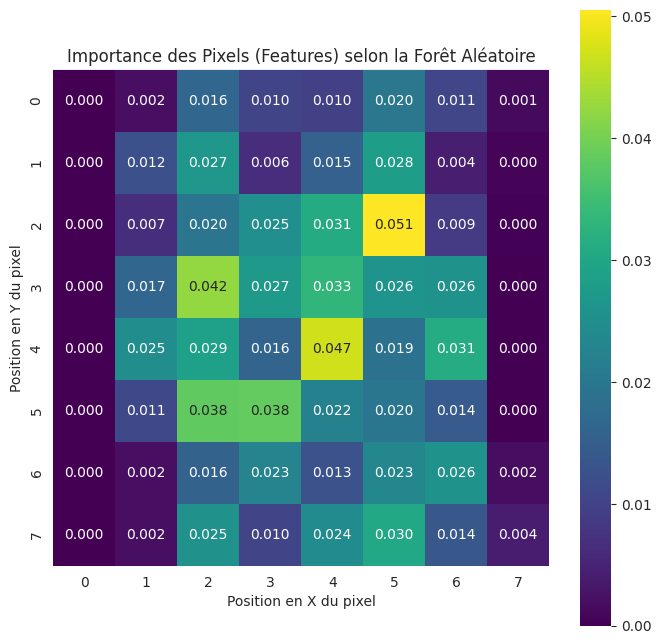

In [34]:
# Extraction de l'importance des caractéristiques
importances = rf_model.feature_importances_

# Remodelage du vecteur d'importance en une image 8x8
importance_map = importances.reshape(8, 8)

# Visualisation de la carte de chaleur
plt.figure(figsize=(8, 8))
sns.heatmap(importance_map, annot=True, fmt=".3f", cmap="viridis", cbar=True, square=True)
plt.title("Importance des Pixels (Features) selon la Forêt Aléatoire")
plt.xlabel("Position en X du pixel")
plt.ylabel("Position en Y du pixel")
plt.show()


On constate assez logiquement que les bords sont peux important dans la détermination car dans le dataset, les bords gauche et droit de l'image sont globalement vide.

Concernant les bords haut ety bas, on pourrait imaginer que c'est le même cas, mais comme les caractères sont par nature verticaux, la 'marge' est souvent utilisés.

## Matrice de confusion

On va maintenant utiliser la matrice de confusion pour déterminer la performance de l'entrainement. Ca permet de savoir si la prédiction colle aux données à évaluer.


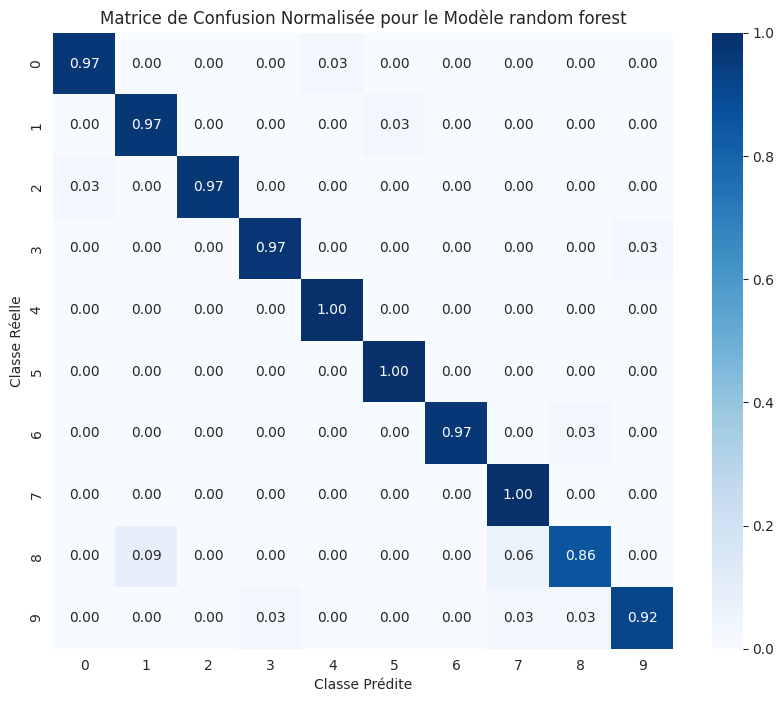

In [35]:
# Calcul de la matrice de confusion pour le meilleur modèle (SVM RBF)
cm = confusion_matrix(y_test, y_pred_rf)

# Normalisation de la matrice pour mieux visualiser les taux d'erreur
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualisation de la matrice de confusion normalisée
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.title("Matrice de Confusion Normalisée pour le Modèle random forest")
plt.ylabel("Classe Réelle")
plt.xlabel("Classe Prédite")
plt.show()

# Conclusion

L'entrainement est globalement trés satisfaisant, cependant on constate une petite faiblesse sur les prédiction du 8 et du 9

Dans le cas du 8, le chiffre est le plus souvent confondu avec le 1 (confusion de 0.09) puis le 7 (confusion de 0.06).

Dans le cas du 9 celui est confondu uniformément avec les chiffres 3, 7 et 8 (confusion de 0.03)

## Axe d'amélioration

Le training sur les digits a été faites avec random tree car cette approche peut être utilisé pour de la regression et de la classification. Ayant utiliser le random tree pour une regression j'ai voulu tester sur une classification. Il serait interessant de tester d'autre model pour voir les performances.



# Sources

* https://medium.com/@sachchitkolekar08/recognizing-handwritten-digits-with-scikit-learn-5e226d159ba1
* https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_digits_simple_classif.html
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* https://www.datacamp.com/tutorial/random-forests-classifier-python